<a href="https://colab.research.google.com/github/fikrifaizz/Real-Time-Fraud-Detection-System/blob/main/notebooks/01_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [21]:
train_identity = pd.read_csv('../data/raw/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('../data/raw/ieee-fraud-detection/train_transaction.csv')
test_identity = pd.read_csv('../data/raw/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('../data/raw/ieee-fraud-detection/test_transaction.csv')

In [22]:
df = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [23]:
# Target distribution
fraud_count = df['isFraud'].value_counts()
fraud_pct = df['isFraud'].value_counts(normalize=True) * 100

print(f"\nTarget Distribution:")
print(f"   Legitimate: {fraud_count[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"   Fraud:      {fraud_count[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"   Imbalance Ratio: 1:{fraud_count[0]/fraud_count[1]:.1f}")

# Column types
print(f"\nColumn Types:")
print(f"   Numeric:     {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"   Categorical: {df.select_dtypes(include=['object']).shape[1]}")


Target Distribution:
   Legitimate: 569,877 (96.50%)
   Fraud:      20,663 (3.50%)
   Imbalance Ratio: 1:27.6

Column Types:
   Numeric:     403
   Categorical: 31



Columns with Missing Values: 414/434

Top 10 Missing Columns:
column  missing_count  missing_pct
 id_24         585793    99.196159
 id_25         585408    99.130965
 id_07         585385    99.127070
 id_08         585385    99.127070
 id_21         585381    99.126393
 id_26         585377    99.125715
 id_27         585371    99.124699
 id_23         585371    99.124699
 id_22         585371    99.124699
 dist2         552913    93.628374


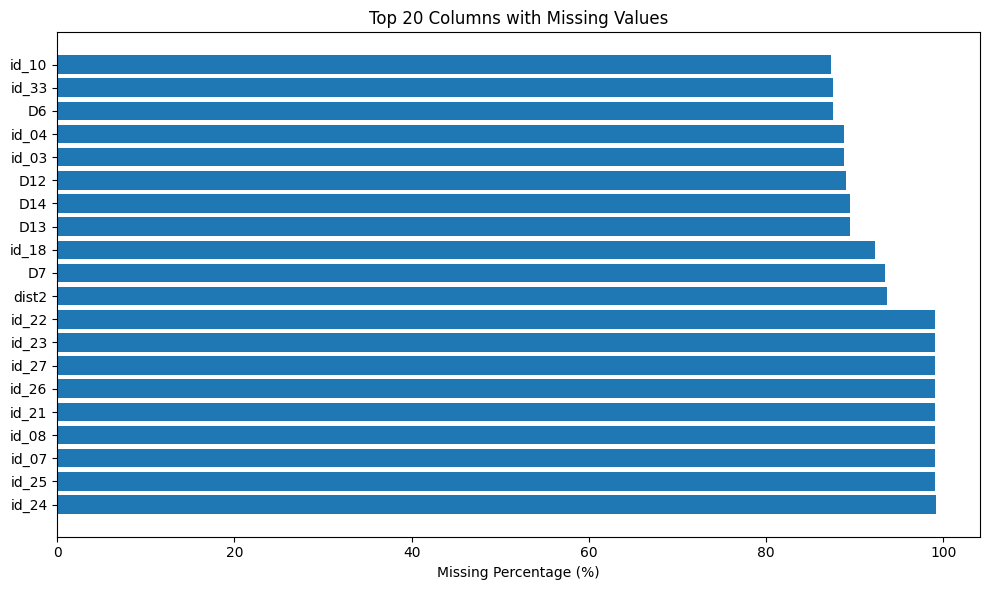

In [24]:
# Hitung missing values
missing = pd.DataFrame({
    'column': df.columns,
    'missing_count': df.isnull().sum(),
    'missing_pct': (df.isnull().sum() / len(df)) * 100
})
missing = missing[missing['missing_pct'] > 0].sort_values('missing_pct', ascending=False)

print(f"\nColumns with Missing Values: {len(missing)}/{len(df.columns)}")
print("\nTop 10 Missing Columns:")
print(missing.head(10).to_string(index=False))

# Visualize top missing columns
plt.figure(figsize=(10, 6))
top_missing = missing.head(20)
plt.barh(top_missing['column'], top_missing['missing_pct'])
plt.xlabel('Missing Percentage (%)')
plt.title('Top 20 Columns with Missing Values')
plt.tight_layout()
plt.show()


Transaction Amount Statistics:
            count        mean         std    min     25%   50%    75%  \
isFraud                                                                 
0        569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1         20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

               max  
isFraud             
0        31937.391  
1         5191.000  


/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_49388/516252424.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([df[df['isFraud']==0]['TransactionAmt'],


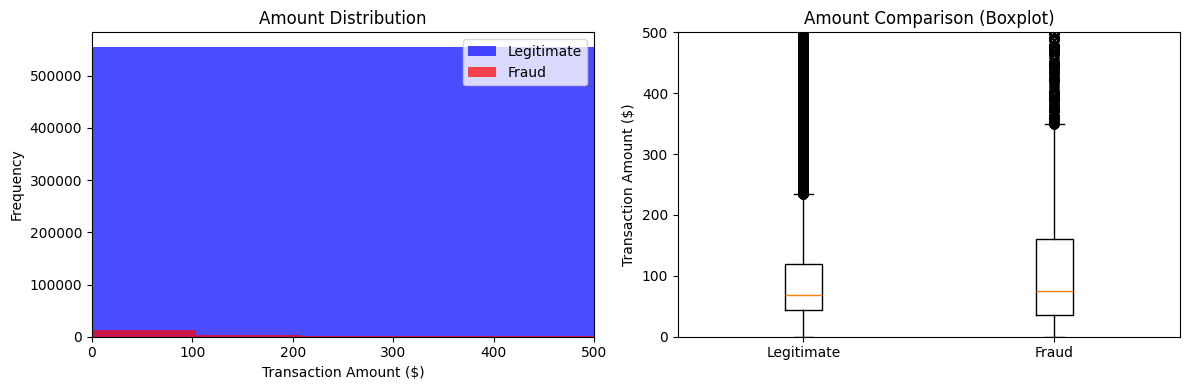

In [25]:
# Transaction Amount Analysis
print("\nTransaction Amount Statistics:")
print(df.groupby('isFraud')['TransactionAmt'].describe())

# Amount distribution by fraud
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(df[df['isFraud']==0]['TransactionAmt'], bins=50, alpha=0.7, label='Legitimate', color='blue')
axes[0].hist(df[df['isFraud']==1]['TransactionAmt'], bins=50, alpha=0.7, label='Fraud', color='red')
axes[0].set_xlabel('Transaction Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Amount Distribution')
axes[0].legend()
axes[0].set_xlim(0, 500)  # Focus pada range yang reasonable

# Boxplot
axes[1].boxplot([df[df['isFraud']==0]['TransactionAmt'], 
                  df[df['isFraud']==1]['TransactionAmt']], 
                 labels=['Legitimate', 'Fraud'])
axes[1].set_ylabel('Transaction Amount ($)')
axes[1].set_title('Amount Comparison (Boxplot)')
axes[1].set_ylim(0, 500)

plt.tight_layout()
plt.show()


Time Pattern Analysis:


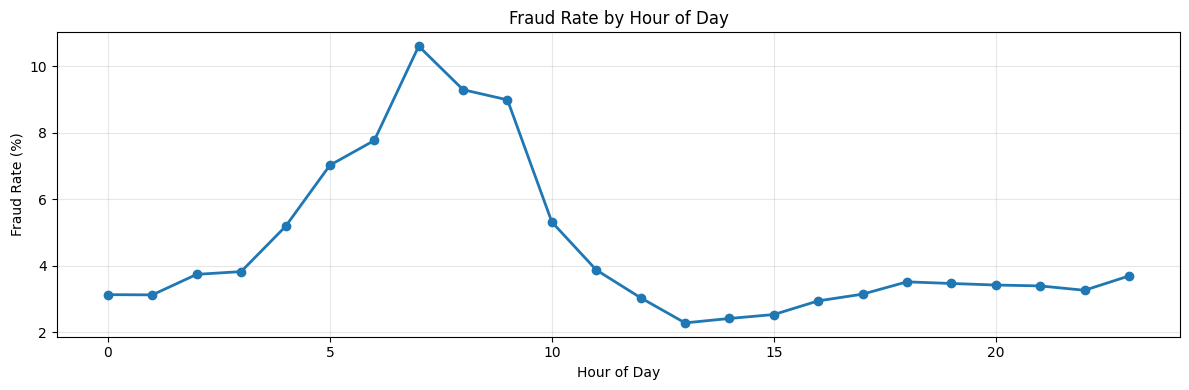


Peak Fraud Hours:
   Hour 07:00 - 10.61% fraud rate
   Hour 08:00 - 9.30% fraud rate
   Hour 09:00 - 9.00% fraud rate


In [26]:
print("\nTime Pattern Analysis:")

# Convert TransactionDT to readable format
df['hour'] = (df['TransactionDT'] % (24*3600)) // 3600
df['day'] = df['TransactionDT'] // (24*3600)

# Fraud by hour
fraud_by_hour = df.groupby(['hour', 'isFraud']).size().unstack(fill_value=0)
fraud_rate_by_hour = (fraud_by_hour[1] / fraud_by_hour.sum(axis=1)) * 100

plt.figure(figsize=(12, 4))
plt.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values, marker='o', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.title('Fraud Rate by Hour of Day')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPeak Fraud Hours:")
top_hours = fraud_rate_by_hour.nlargest(3)
for hour, rate in top_hours.items():
    print(f"   Hour {int(hour):02d}:00 - {rate:.2f}% fraud rate")

In [27]:
# Product Code Analysis (ProductCD)
print("\nProduct Code Distribution:")
product_fraud = pd.crosstab(df['ProductCD'], df['isFraud'], normalize='index') * 100
print(product_fraud)

# Card Type Analysis (card4, card6)
if 'card4' in df.columns:
    print("\nCard Type (card4) Fraud Rate:")
    card4_fraud = pd.crosstab(df['card4'], df['isFraud'], normalize='index') * 100
    print(card4_fraud)


Product Code Distribution:
isFraud            0          1
ProductCD                      
C          88.312731  11.687269
H          95.233769   4.766231
R          96.217406   3.782594
S          94.100447   5.899553
W          97.960061   2.039939

Card Type (card4) Fraud Rate:
isFraud                   0         1
card4                                
american express  97.130163  2.869837
discover          92.271839  7.728161
mastercard        96.566905  3.433095
visa              96.524390  3.475610


In [28]:
print("DATA CLEANING STRATEGY")

# Identify columns to drop
high_missing = missing[missing['missing_pct'] > 90]['column'].tolist()
print(f"\nColumns to drop (>90% missing): {len(high_missing)}")

# Clean data
df_clean = df.drop(columns=high_missing)
print(f"\nShape after dropping: {df_clean.shape}")

# Fill numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

# Fill categorical columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna('Unknown', inplace=True)

print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

DATA CLEANING STRATEGY

Columns to drop (>90% missing): 12

Shape after dropping: (590540, 424)


/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_49388/2606884189.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)
/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_49388/2606884189.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

Missing values after cleaning: 0


In [32]:
Path('../data/processed').mkdir(parents=True, exist_ok=True)

# Save cleaned data
df_clean.to_csv('../data/processed/cleaned_data.csv', index=False)
print(f"Saved: ../data/processed/cleaned_data.csv")
print(f"   Shape: {df_clean.shape}")
print(f"   Size: {Path('../data/processed/cleaned_data.csv').stat().st_size / 1024**2:.1f} MB")

Saved: ../data/processed/cleaned_data.csv
   Shape: (590540, 424)
   Size: 1057.0 MB
